In [65]:
from qiskit import *
import numpy as np

In [66]:
def amplitudePartialSum(qc, M):
    n = qc.num_qubits

    if (M & (M - 1)) == 0:  # M is power of 2
        r = int(np.log2(M))
        for i in range(r):
            qc.h(i)
        return qc

    # M is not a power of 2 

    # compute l[0],l[1],...,l[k]
    # an ordered sequence of numbers representing 
    # the locations of 1 in the reverse binary representation of M
    l = [] 
    for pos in range(n):
        if (M >> pos) & 1:
            l.append(pos)
    k = len(l) - 1   

    Mm = M - 2**l[k]
    for m in range(k-1, 0, -1):
        # controlled Hadamard (H) gate on |qi⟩ for i=l[m+1]−1, l[m+1]−2,…, l[m]+1, l[m],
        # conditioned on ql[m+1] being equal to 0.
        qc.x(l[m+1])
        for i in range(l[m],l[m+1]):
            qc.ch(l[m+1], i)
        qc.x(l[m+1])

        Mm = Mm - 2**l[m]

        # controlled RY(𝜃m) gate, with 𝜃m=2*arccos(sqrt((2**l[m])/(M-Mm))), 
        # on ql[m+1] conditioned on ql[m] being 0
        theta_m = 2*np.arccos(np.sqrt((2**l[m])/(M-Mm)))
        qc.x(l[m])
        qc.cry(theta_m, l[m], l[m+1])
        qc.x(l[m])

    # controlled Hadamard (H) gate on |qi⟩ for i=l[1]−1, l[1]−2,…, l[0]+1, l[0],
    # conditioned on ql[1] being equal to 0.
    qc.x(l[1])
    for i in range(l[0],l[1]):
        qc.ch(l[1], i)
    qc.x(l[1])

    # RY(𝜃0) gate, with 𝜃0=2*arccos(sqrt((2**l[m])/(M-Mm))), on ql[1] 
    theta_m = 2*np.arccos(np.sqrt((Mm)/(M)))
    qc.ry(theta_m, l[1])


    # if M is even r, then apply Hadamard gates on the rightmost l[0] qubits
    if(l[0]>0):
        for i in range(0,l[0]):
            qc.h(i)

    # X gate on qi for i= l[1], l[2],…, l[k]
    for i in range(1, k+1):
        qc.x(l[i])

    return qc

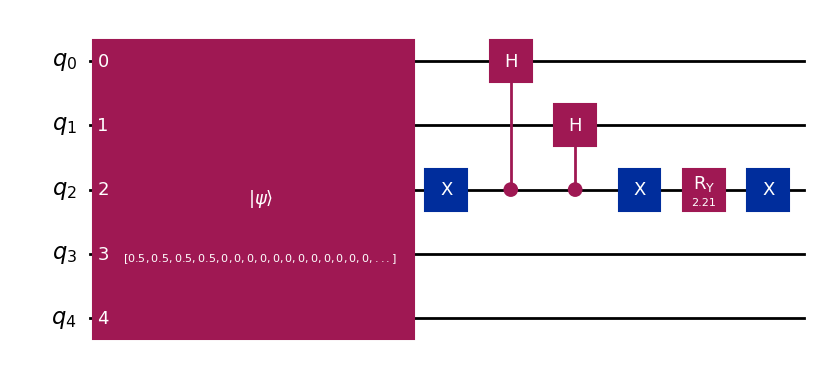

In [67]:
n = 5
N=2**n
qc = QuantumCircuit(n)
f = np.array([1, 1, 1, 1] + [0]*(N-4), dtype=complex)
scale=np.linalg.norm(f)
f1 = f / scale
qc.initialize(f1, list(range(n)))

M = 5

amplitudePartialSum(qc, M)


qc.draw(output='mpl')


In [69]:
from qiskit.quantum_info import Statevector

sv = Statevector.from_instruction(qc)
amps = sv.data

amp_0 = amps[0]

print("Amplitude of |0> =", amp_0)
expected = (1/np.sqrt(M)) * np.sum(f1[:M])
print("Expected =", expected)
print("Difference =", abs(amp_0 - expected))

print("Sm =", np.sqrt(M)*amp_0*scale )
print("Expected =", np.sum(f[:M]))
print("Difference =", abs(np.sqrt(M)*amp_0*scale - np.sum(f[:M])))




Amplitude of |0> = (0.8944271909999156+0j)
Expected = (0.8944271909999159+0j)
Difference = 2.220446049250313e-16
Sm = (3.999999999999999+0j)
Expected = (4+0j)
Difference = 8.881784197001252e-16
